In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
print(cv2.__version__)

4.2.0


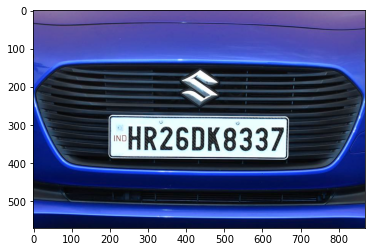

570


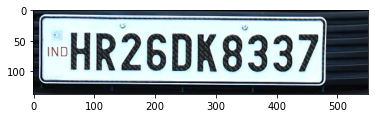

In [3]:
def plateFinding(img):
    print(len(img))
    copiedImg=img.copy()
    cas=cv2.CascadeClassifier('./indian_license_plate.xml')
    plateRect=cas.detectMultiScale(copiedImg, scaleFactor=1.3, minNeighbors=7)
    for (x,y,w,h) in plateRect:
        plate=copiedImg[y:y+h, x:x+w]
    return plate
image=cv2.imread('test.jpg')
plt.imshow(image)
plt.show()
outPlate=plateFinding(image)
plt.imshow(outPlate)
plt.show()

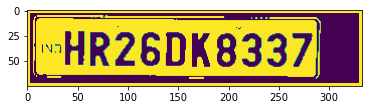

Preprocessing Again :


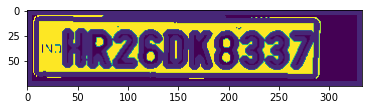

Drawing Contours


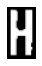

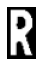

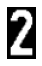

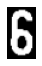

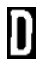

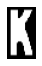

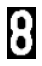

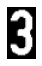

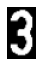

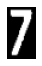

In [14]:
def findContours(dim,img):
    cntrs,_=cv2.findContours(img.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    lW=dim[0]
    uW=dim[1]
    lH=dim[2]
    uH=dim[3]
    cntrs=sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    copiedImageCntrs=img.copy()
    cv2.drawContours(copiedImageCntrs,cntrs,-1,(28,67,211),3)
    plt.imshow(copiedImageCntrs)
    plt.show()
    print("Drawing Contours")
    xCntrList=[]
    targetCont=[]
    imgRES=[]
    for cnt in cntrs:
        ix,iy,iw,ih=cv2.boundingRect(cnt)
        if iw>lW and iw<uW and ih>lH and ih<uH:
            xCntrList.append(ix)
            charCopy=np.zeros((44,24))
            char=img[iy:iy+ih, ix:ix+iw]
            char=cv2.resize(char,(20,40))
            char=cv2.subtract(255, char)
            charCopy[2:42,2:22]=char
            charCopy[0:2,:]=0
            charCopy[:,0:2]=0
            charCopy[42:44,:]=0
            charCopy[:,22:24]=0
            imgRES.append(charCopy)
    indices=sorted(range(len(xCntrList)),key=lambda k: xCntrList[k])
    imgRESCopy=[]
    for idx in indices:
        imgRESCopy.append(imgRES[idx])
    imgRES=np.array(imgRESCopy)
    return imgRES

def segm(image):
    img=cv2.resize(image, (333,75))
    imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    _, imgBinary=cv2.threshold(imgGray,200,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
   
    imgErode=cv2.erode(imgBinary,(3,3))
    imgDilate=cv2.dilate(imgErode,(3,3))
    
    LW=imgDilate.shape[0]
    LH=imgDilate.shape[1]
    imgDilate[0:3,:]=255
    imgDilate[:,0:3]=255
    imgDilate[72:75,:]=255
    imgDilate[:,330:333]=255
    dimensions=[LW/6,LW/2,LH/10,2*LH/3]
    plt.imshow(imgDilate)
    plt.show()
    print("Preprocessing Again :")
    charList=findContours(dimensions,imgDilate)
    return charList

out=segm(outPlate)
for i in range(0,len(out)):
    plt.subplot(1,10,i+1)
    plt.imshow(out[i], cmap='gray')
    plt.axis('off')
    plt.show()

In [15]:
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *

In [18]:
train_path='data/train'
validation_path='data/val'
classesList=os.listdir(train_path)
print(classesList)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_A', 'class_B', 'class_C', 'class_D', 'class_E', 'class_F', 'class_G', 'class_H', 'class_I', 'class_J', 'class_K', 'class_L', 'class_M', 'class_N', 'class_O', 'class_P', 'class_Q', 'class_R', 'class_S', 'class_T', 'class_U', 'class_V', 'class_W', 'class_X', 'class_Y', 'class_Z']


In [19]:
trnB=ImageDataGenerator().flow_from_directory(train_path,target_size=(28,28),batch_size=1, class_mode='categorical')
valB=ImageDataGenerator().flow_from_directory(validation_path,target_size=(28,28),batch_size=1, class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [21]:
print(valB.class_indices)

{'class_0': 0, 'class_1': 1, 'class_2': 2, 'class_3': 3, 'class_4': 4, 'class_5': 5, 'class_6': 6, 'class_7': 7, 'class_8': 8, 'class_9': 9, 'class_A': 10, 'class_B': 11, 'class_C': 12, 'class_D': 13, 'class_E': 14, 'class_F': 15, 'class_G': 16, 'class_H': 17, 'class_I': 18, 'class_J': 19, 'class_K': 20, 'class_L': 21, 'class_M': 22, 'class_N': 23, 'class_O': 24, 'class_P': 25, 'class_Q': 26, 'class_R': 27, 'class_S': 28, 'class_T': 29, 'class_U': 30, 'class_V': 31, 'class_W': 32, 'class_X': 33, 'class_Y': 34, 'class_Z': 35}


In [26]:
model=Sequential([
    Conv2D(32,(24,24), input_shape=(28,28,3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(36, activation='softmax'),
])
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit_generator(trnB, steps_per_epoch=864,validation_data=valB, validation_steps=216, epochs=30)

Epoch 1/30
864/864 [==============================] - 32s 37ms/step - loss: 10.3227 - accuracy: 0.3125 - val_loss: 0.0022 - val_accuracy: 0.7824
Epoch 2/30
864/864 [==============================] - 29s 33ms/step - loss: 1.3424 - accuracy: 0.6725 - val_loss: 3.3576e-04 - val_accuracy: 0.8704
Epoch 3/30
864/864 [==============================] - 27s 31ms/step - loss: 1.0336 - accuracy: 0.7801 - val_loss: 7.9695e-04 - val_accuracy: 0.8796
Epoch 4/30
864/864 [==============================] - 28s 32ms/step - loss: 0.7169 - accuracy: 0.8634 - val_loss: 0.0246 - val_accuracy: 0.9491
Epoch 5/30
864/864 [==============================] - 29s 34ms/step - loss: 0.8477 - accuracy: 0.8542 - val_loss: 0.0000e+00 - val_accuracy: 0.9398
Epoch 6/30
864/864 [==============================] - 27s 32ms/step - loss: 0.6155 - accuracy: 0.8877 - val_loss: 0.0000e+00 - val_accuracy: 0.9769
Epoch 7/30
864/864 [==============================] - 28s 32ms/step - loss: 0.8543 - accuracy: 0.8993 - val_loss: 0.000

In [29]:
model.save('TrainedModelofAnpr.h5')
print("SAVED")

SAVED


In [30]:
from keras.models import load_model
preTrained=load_model('TrainedModelofAnpr.h5')
print(preTrained.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        55328     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_6 (Dense)              (None, 36)                4644      
Total params: 862,916
Trainable params: 862,916
Non-trainable params: 0
________________________________________________

In [31]:
def fixIt(img):
    newImg=np.zeros((28,28,3))
    for i in range(3):
        newImg[:,:,i]=img
    return newImg
def showing():
    dic={}
    characters='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i]=c
    output=[]
    for i,ch in enumerate(out):
        img_=cv2.resize(ch,(28,28))
        img=fixIt(img_)
        img=img.reshape(1,28,28,3)
        y_=preTrained.predict_classes(img)[0]
        charac=dic[y_]
        output.append(charac)
    plate_Number=''.join(output)
    return plate_Number
print(showing())
    

HRZSDK8337


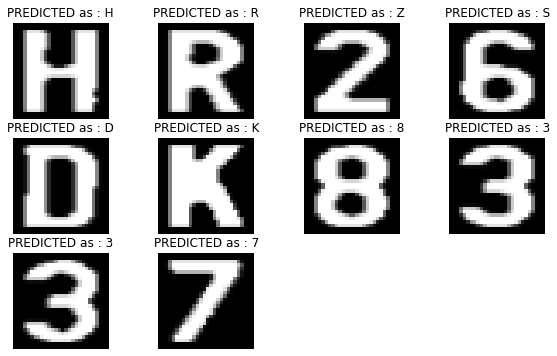

In [32]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(out):
    img=cv2.resize(ch,(28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'PREDICTED as : {showing()[i]}')
    plt.axis('off')
plt.show()